# Let's begin! 
### First we import some useful python libraries...

In [1]:
## Imports
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting

## Download data

In [2]:
n_subjects = 100
parcel = "rois_ho"  # 'rois_ho' or 'rois_aal
data = datasets.fetch_abide_pcp(n_subjects=n_subjects, derivatives=[parcel], data_dir="./")

/home/nikhil/anaconda3/envs/qlsc612/lib/python3.9/site-packages/nilearn/datasets/func.py:1020: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


## Phenotypes and Demographics

In [3]:
pheno = pd.DataFrame(data["phenotypic"]).drop(columns=["i", "Unnamed: 0"])
pheno.head()

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
1,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
3,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
4,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,1,R,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1


In [4]:
site_counts = pheno["SITE_ID"].value_counts()
dx_counts = pheno["DX_GROUP"].value_counts()

print(f"Dx count:\n{dx_counts}\n\nScanning site_counts:\n{site_counts}")

Dx count:
1    50
2    50
Name: DX_GROUP, dtype: int64

Scanning site_counts:
PITT    50
OLIN    28
OHSU    22
Name: SITE_ID, dtype: int64


## MRI features

### These are stored in a list, where each list element is a subject-specific feature matrix
### Subject specific feature matrix: timepoints x ROIs
### ROIs are defined based on [harvard_oxford atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_harvard_oxford.html) or [AAL atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_aal.html)

In [5]:
features = data[parcel]

print(f"Number of samples: {len(features)}")

subject_feature_shape = features[0].shape

print(f"subject_feature_shape: {subject_feature_shape}")

Number of samples: 100
subject_feature_shape: (196, 111)


## Let's see how the atlas looks like

/home/nikhil/anaconda3/envs/qlsc612/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


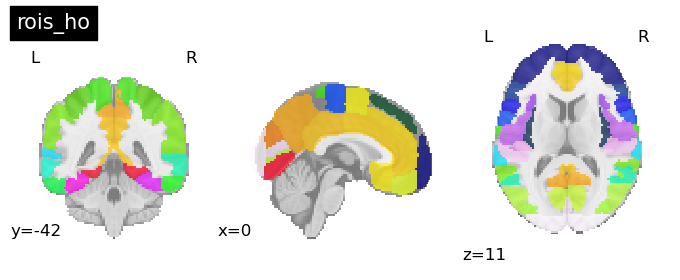

In [6]:
if parcel == "rois_ho":
    atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
else:
    atlas = datasets.fetch_atlas_aal()

plotting.plot_roi(atlas.maps, draw_cross=False, title=parcel)

## And the subject-specific feature matrix

Text(0.5, 1.0, 'Functional data timeseries')

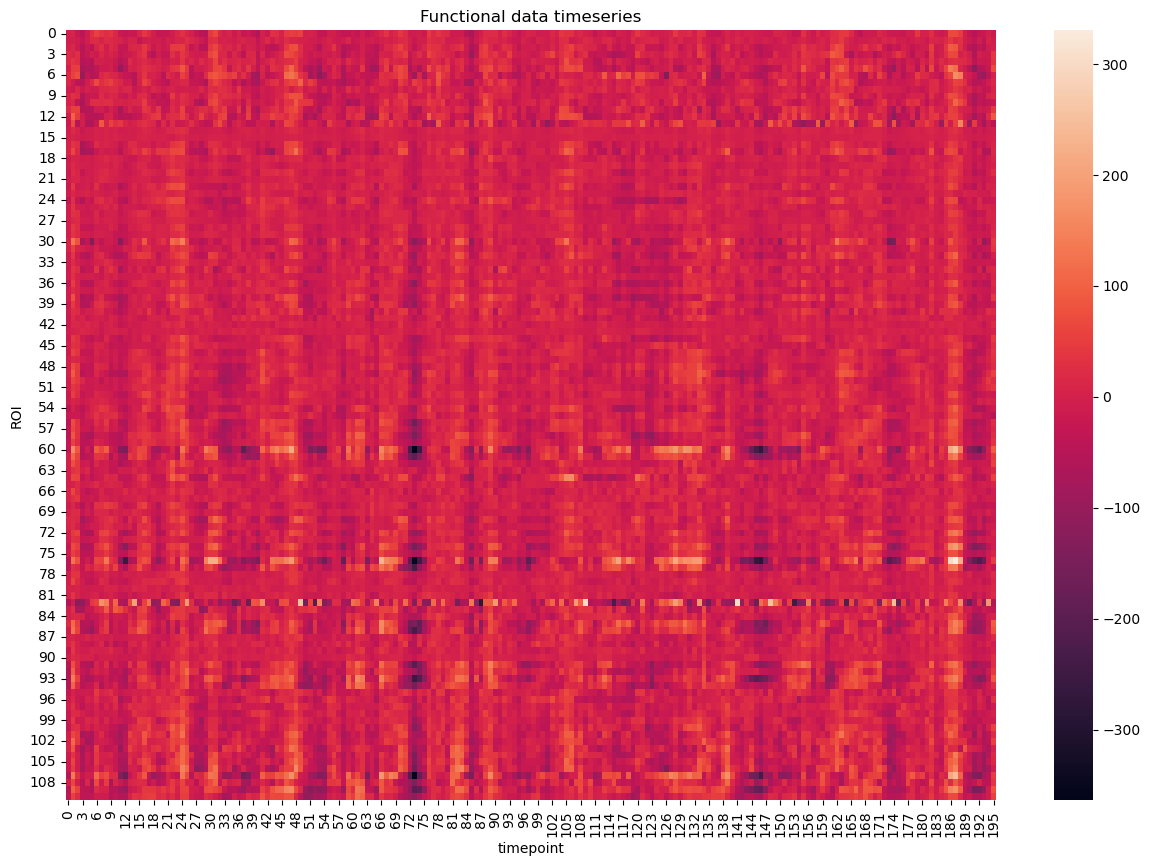

In [7]:
f, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(features[0].T, ax=ax)
g.set_xlabel("timepoint")
g.set_ylabel("ROI")
g.set_title("Functional data timeseries")

## Preprocessing / feature engineering

### Commonly functional (timeseries) neuroimaging data is represented as functional connectome aka network ake graph. 

Shape connectome: (111, 111)


Text(0.5, 1.0, 'Connectome')

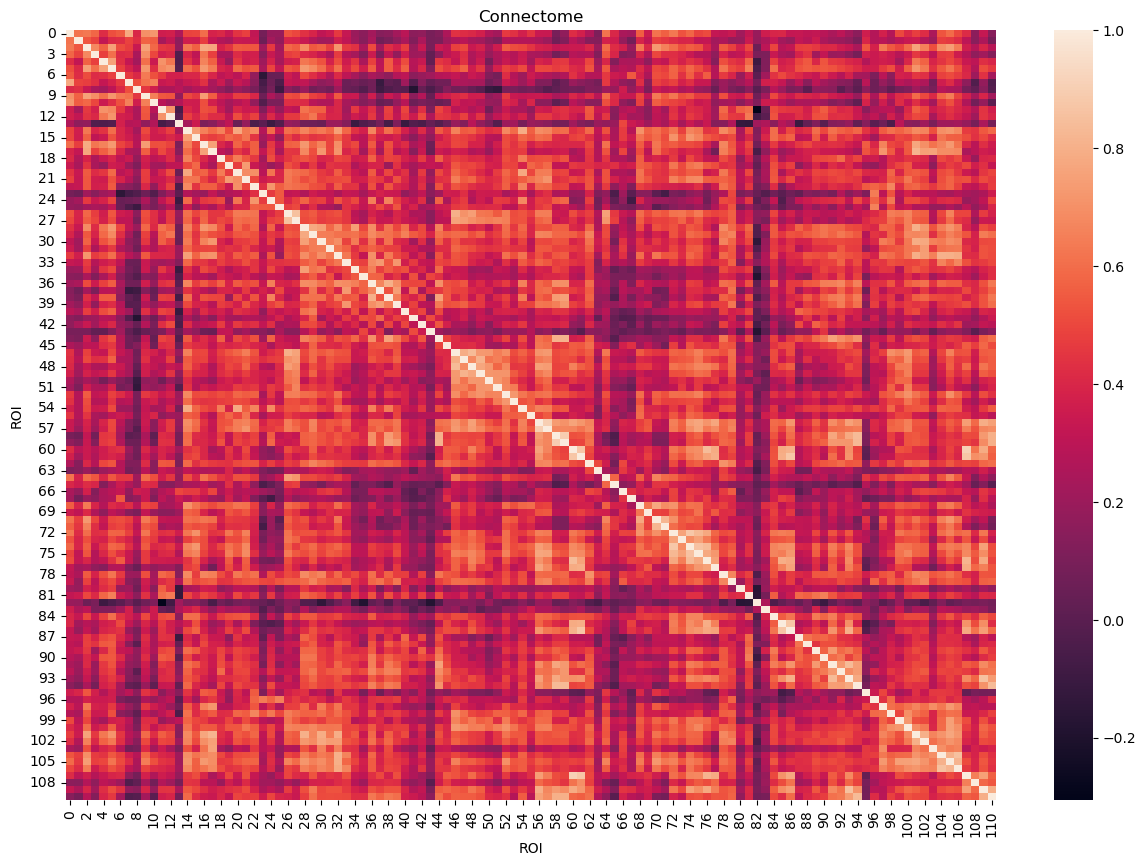

In [8]:
connectome_matrix = ConnectivityMeasure(kind="correlation")
connectome_matrix = connectome_matrix.fit_transform([features[0]])[0]
print(f"Shape connectome: {connectome_matrix.shape}")

f, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(connectome_matrix, ax=ax)
g.set_xlabel("ROI")
g.set_ylabel("ROI")
g.set_title("Connectome")

In [9]:
# Extract lower (or upper) triangle entrees (excluding diagonal)
tril_idx = np.tril_indices(len(connectome_matrix), k=-1)
features_flat = connectome_matrix[tril_idx]
print(f"Number of features per subject: {len(features_flat)}")

Number of features per subject: 6105


## Now do this for all subjects!

In [11]:
# defs are definitely useful!


def extract_connectome_features(func_data, measure):
    """A function to calculate connnectome based on timeseries data and similarity measure"""
    connectome_matrix = measure.fit_transform([func_data])[0]
    tril_idx = np.tril_indices(len(connectome_matrix), k=-1)
    flat_features = connectome_matrix[tril_idx]

    return flat_features

## Note

here we are pre-processing each image independently i.e. not using any group-level information for scaling / normalization / feature transformation (e.g. PCA). Therefore there is no "double dipping" or leakage of information from a test set. This sort of independent image pre-processing, we can do on entire dataset without creating train-test splits first and then defining feature-set on the training data only. 

In [12]:
correlation_measure = ConnectivityMeasure(kind="correlation")

flat_features_list = []
for func_data in features:
    flat_features = extract_connectome_features(func_data, correlation_measure)
    flat_features_list.append(flat_features)

print(f"Length of flat_features_list {len(flat_features_list)}")

Length of flat_features_list 100


## Input data matrix (n_samples, n_features)

In [13]:
X = np.array(flat_features_list)

print(f"Input data (X) shape: {X.shape}")

# Memory intensive #

# g = sns.heatmap(flat_features_array)
# g.set_xlabel('Connection strength')
# g.set_ylabel('ROI')
# g.set_title('Connectome')

Input data (X) shape: (100, 6105)


## Output labels (y): Diagnosis


In [14]:
from sklearn import preprocessing

outcome = "DX_GROUP"
y = pheno[outcome]
y_counts = y.value_counts()

print(f"Unique output clasess:\n{y_counts}")

# Encode labels to integer categories
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

Unique output clasess:
1    50
2    50
Name: DX_GROUP, dtype: int64


## Okay now we have our input data (X) and output data (y) in the following format
<img src="./QLS_ML_terminology.png" alt="terms" width="800"/>


### Save `ML-ready` data

In [15]:
save_dataset = False

ds_name = "my_ML_dataset"
save_path = f"../../data/{ds_name}"

if save_dataset:
    print(f"Saving dataset to {save_path}")
    print(f"Dataset X_shape: {X.shape}, y_shape: {y.shape}")
    np.savez(save_path, X=X, y=y)

### Load the dataset (sanity check)

In [16]:
print(f"Loading dataset from: {save_path}")
my_ds = np.load(save_path + ".npz")
X = my_ds["X"]
y = my_ds["y"]
print(f"Loaded dataset X_shape: {X.shape}, y_shape: {y.shape}")

Loading dataset from: ../../data/my_ML_dataset
Loaded dataset X_shape: (100, 6105), y_shape: (100,)
